In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl,np,sklearn,tf,keras:
    print(module.__name__,module.__version__)

Using TensorFlow backend.


2.1.0
sys.version_info(major=3, minor=6, micro=10, releaselevel='final', serial=0)
matplotlib 3.1.3
numpy 1.18.1
sklearn 0.22.1
tensorflow 2.1.0
keras 2.3.1


In [2]:
train_dir = os.path.join("plantseeding/train" )
test_dir = os.path.join("plantseeding/test" )
label_file = os.path.join("plantseeding/sample_submission.csv" )
print(os.path.exists(train_dir))
print(os.path.exists(test_dir))
print(os.path.exists(label_file))

True
True
True


In [3]:
label = pd.read_csv(label_file,header=0)
print(label)

              file     species
0    0021e90e4.png  Sugar beet
1    003d61042.png  Sugar beet
2    007b3da8b.png  Sugar beet
3    0086a6340.png  Sugar beet
4    00c47e980.png  Sugar beet
..             ...         ...
789  fea355851.png  Sugar beet
790  fea3da57c.png  Sugar beet
791  fef2ade8c.png  Sugar beet
792  ff65bc002.png  Sugar beet
793  ffc6f8527.png  Sugar beet

[794 rows x 2 columns]


In [4]:
height = 128
width = 128
channels = 3
batch_size = 64
num_classes = 12

trian_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                        rotation_range = 40,
                                                        width_shift_range = 0.2,
                                                        height_shift_range = 0.2,
                                                        shear_range = 0.2,
                                                        zoom_range = 0.2,
                                                        horizontal_flip = True,
                                                        fill_mode = 'nearest')
train_generator = trian_datagen.flow_from_directory(train_dir,
                                                  target_size = (height,width),
                                                  batch_size = batch_size,
                                                  seed = 7,
                                                  shuffle = True,
                                                  class_mode = "categorical")
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(train_dir,
                                                  target_size = (height,width),
                                                  batch_size = batch_size,
                                                  seed = 7,
                                                  shuffle = False,
                                                  class_mode = "categorical")
train_num = train_generator.samples
test_num = test_generator.samples
print(train_num,test_num)

Found 4750 images belonging to 12 classes.
Found 4750 images belonging to 12 classes.
4750 4750


In [5]:
for i in range(2):
    x,y = train_generator.next()
    print(x.shape,y.shape)
    print(y)

(64, 128, 128, 3) (64, 12)
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [6]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters = 64,kernel_size = 3,padding = 'same',
                       activation = 'relu',input_shape = [width,height,channels]),
    keras.layers.MaxPool2D(pool_size = 2),
    
    keras.layers.Conv2D(filters = 128,kernel_size = 3,padding = 'same',
                       activation = 'relu'),
    keras.layers.MaxPool2D(pool_size = 2),
    
    keras.layers.Conv2D(filters = 256,kernel_size = 3,padding = 'same',
                       activation = 'relu'),
    keras.layers.Conv2D(filters = 256,kernel_size = 3,padding = 'same',
                       activation = 'relu'),
    keras.layers.MaxPool2D(pool_size = 2),

    keras.layers.AlphaDropout(rate=0.5),
    
    keras.layers.Flatten(),
    keras.layers.Dense(1024,activation = 'relu'),
    keras.layers.AlphaDropout(rate=0.5), 
    keras.layers.Dense(num_classes,activation = 'softmax'),
])
model.compile(loss = "categorical_crossentropy",
             optimizer = "adam",
             metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 256)       295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 256)       590080    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 256)      

In [7]:
epochs = 50
logdir = os.path.join("VGG_Copy_50epchos_result" )
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir,
                                 "Vgg_model.h5")
callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file,
                                   save_best_only = True)
]
history = model.fit_generator(train_generator,
                             steps_per_epoch = train_num//batch_size,
                             epochs = epochs,
                              validation_data = test_generator,
                              validation_steps = test_num//batch_size
                             )

Epoch 1/50
74/74 [==============================] - 392s 5s/step - loss: 3.1305 - accuracy: 0.0920 - val_loss: 2.5076 - val_accuracy: 0.1381
Epoch 2/50
74/74 [==============================] - 377s 5s/step - loss: 2.8086 - accuracy: 0.1014 - val_loss: 4.4224 - val_accuracy: 0.1398
Epoch 3/50
74/74 [==============================] - 353s 5s/step - loss: 2.7401 - accuracy: 0.1167 - val_loss: 4.5657 - val_accuracy: 0.3178
Epoch 4/50
74/74 [==============================] - 353s 5s/step - loss: 2.4044 - accuracy: 0.1916 - val_loss: 3.7118 - val_accuracy: 0.3485
Epoch 5/50
74/74 [==============================] - 348s 5s/step - loss: 2.1829 - accuracy: 0.2507 - val_loss: 2.5097 - val_accuracy: 0.3498
Epoch 6/50
74/74 [==============================] - 347s 5s/step - loss: 2.1448 - accuracy: 0.2473 - val_loss: 2.7071 - val_accuracy: 0.3668
Epoch 7/50
74/74 [==============================] - 350s 5s/step - loss: 2.1061 - accuracy: 0.2587 - val_loss: 0.9537 - val_accuracy: 0.3841
Epoch 8/50
74

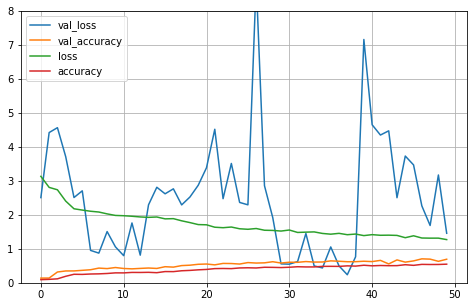

In [12]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,8)
    plt.show()
    
plot_learning_curves(history)